## Project

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import xarray as xr
#from netCDF4 import Dataset
import tempfile
from scipy.spatial.distance import cdist
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from sklearn import ensemble
import matplotlib.pyplot as plt
import shap
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import xgboost as xgb

### 1. Data Collection

#### 1.1 Biomass data

Spatio-temporal data for walleye pollock in the Gulf of Alaska extracted from the NOAA Fisheries website: https://apps-st.fisheries.noaa.gov/dismap/DisMAP.html#single-species-distributions

In [2]:
wp_gulf_alaska = pd.read_csv("wp_gulf_alaska.csv")
wp_gulf_alaska.head()

,HaulID,Stratum,LAT,LON,Depth,Year,wtcpue
0,021-198403-001,350,55.98767,-134.59517,346,1984,0.0000
1,021-198403-002,251,55.63200,-134.22900,225,1984,4.7482
2,021-198403-003,151,55.21450,-133.88733,117,1984,1.0413
3,021-198403-006,151,55.13300,-133.87100,141,1984,1.3450
4,021-198403-007,151,55.12550,-134.00167,170,1984,0.2030


Columns:
- HaulID / Stratum: characterizes the survey expedition and catch throw.
- LAT / LON: Latitude and Longitude of survey catch
- Depth: Sea depth measured in meters below sea level.
- Year: No other timestamp is provided. However, documentation specify that all surveys have been conducted during summer months.
- wtcpue: survey catch measured in kg per ha.


In [3]:
wp_gulf_alaska = wp_gulf_alaska.rename(columns={"HaulID": "haul_id", "Stratum": "stratum", "LAT": "lat", "LON": "lon", "Depth":'depth', "Year": "year"})
wp_gulf_alaska['year'] = wp_gulf_alaska['year'].astype('int64')
wp_gulf_alaska.head()

,haul_id,stratum,lat,lon,depth,year,wtcpue
0,021-198403-001,350,55.98767,-134.59517,346,1984,0.0000
1,021-198403-002,251,55.63200,-134.22900,225,1984,4.7482
2,021-198403-003,151,55.21450,-133.88733,117,1984,1.0413
3,021-198403-006,151,55.13300,-133.87100,141,1984,1.3450
4,021-198403-007,151,55.12550,-134.00167,170,1984,0.2030


#### 1.2 Oceanographic data

We web-scrape temperature and salinity geospatial data from HyCOM (Hybrid Coordinate Ocean Model) using their NCSS request URL. Since there is too much data, we have decided to only get a sample from the first day of each summer month (July 1st, August 1st and September 1st). Of course, including more points should improve our model. Then again, we don't have a timestamp associated with each survey, just the year.

We will extract data from this geographic region:
- North limit: 60.32
- South limit: 52.41
- West limit: -170
- East limit: -132.5

Unfortunately, we do not have data prior to 1995. 

In [10]:
# Define the list of years and months
year_list = [1996, 1999, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]
month_list = [7, 8, 9]
this_folder = os.getcwd()
data_folder = this_folder + '\\temp' # '\\temp' on a windows machine

if not os.path.exists('ocean_data.csv'):
  # create data folder if it doesn't exists 
  if not os.path.exists(data_folder):
    os.mkdir(data_folder)
  
  # Create an empty DataFrame to store the results
  df_all = pd.DataFrame()

  # Loop over each desired year and month, and add a progress bar
  for year in year_list:
      for month in tqdm(month_list, desc=f'{year}'):
          # Define the date string
          date_str = f'{year}-{month:02d}-01T09:00:00Z'
          # Define the URL with the fixed parameters
          if year <=2015:
              url = "https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_53.X/data/"+str(year)+"?var=salinity_bottom&var=water_temp_bottom&north=60.32&west=-170&east=-132.5&south=52.41&horizStride=1&vertCoord=&accept=netcdf4"
          elif year == 2017:
              url = "https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_57.7?var=salinity_bottom&var=water_temp_bottom&north=60.32&west=-170&east=-132.5&south=52.41&horizStride=1&vertCoord=&accept=netcdf4"
          else:
              url = "https://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_93.0/ts3z?var=salinity_bottom&var=water_temp_bottom&north=60.32&west=-170&east=-132.5&south=52.41&horizStride=1&vertCoord=&accept=netcdf4"
          
          my_file = os.path.join(this_folder, 'temp', f'example-{date_str[:10]}.nc4')
          # Add the date parameter to the URL
          url_day = f'{url}&time={date_str}'
          # Download the data and save it to a file
          downloaded_obj = requests.get(url_day)
          with open(my_file, "wb") as file:
              file.write(downloaded_obj.content)
              del downloaded_obj
          # Open the NetCDF file and convert it to a pandas DataFrame
          ds = xr.open_dataset(my_file)
          df_temp = ds.to_dataframe().reset_index()
          # Append the DataFrame to the overall DataFrame
          df_all = pd.concat([df_all, df_temp], ignore_index=True)

  df_all.to_csv('ocean_data.csv', index=False)

2019: 100%|██████████| 3/3 [01:37<00:00, 32.47s/it]


In [4]:
ocean_data_df = pd.read_csv('ocean_data.csv')
ocean_data_df.head()

,time,lat,lon,salinity_bottom,water_temp_bottom
0,1996-07-01 09:00:00,52.400002,-170.000000,34.223000,3.535999
1,1996-07-01 09:00:00,52.400002,-169.919983,34.287003,3.223999
2,1996-07-01 09:00:00,52.400002,-169.839966,34.330000,3.050999
3,1996-07-01 09:00:00,52.400002,-169.760010,34.323000,3.139000
4,1996-07-01 09:00:00,52.400002,-169.679993,34.324000,3.146000


In [5]:
ocean_data_df['time'] = pd.to_datetime(ocean_data_df['time'])
ocean_data_df['year'] = ocean_data_df['time'].dt.strftime('%Y').astype(int)
ocean_data_df['lon'] = np.where(ocean_data_df['year'] == 2019, -ocean_data_df['lon'], ocean_data_df['lon'])
ocean_data_df.head()

,time,lat,lon,salinity_bottom,water_temp_bottom,year
0,1996-07-01 09:00:00,52.400002,-170.000000,34.223000,3.535999,1996
1,1996-07-01 09:00:00,52.400002,-169.919983,34.287003,3.223999,1996
2,1996-07-01 09:00:00,52.400002,-169.839966,34.330000,3.050999,1996
3,1996-07-01 09:00:00,52.400002,-169.760010,34.323000,3.139000,1996
4,1996-07-01 09:00:00,52.400002,-169.679993,34.324000,3.146000,1996


In [6]:
# min_lat = wp_gulf_alaska['lat'].min()
# max_lat = wp_gulf_alaska['lat'].max()
# min_lon = wp_gulf_alaska['lon'].min()
# max_lon = wp_gulf_alaska['lon'].max()
# print(min_lat)
# print(max_lat)
# print(min_lon)
# print(max_lon)

min_lat = ocean_data_df['lat'].min()
max_lat = ocean_data_df['lat'].max()
min_lon = ocean_data_df['lon'].min()
max_lon = ocean_data_df['lon'].max()
print(min_lat)
print(max_lat)
print(min_lon)
print(max_lon)

52.400001525878906
60.31999969482422
-227.52001953125
-132.47998046875


In [7]:
offset = 2
small_ocean_data_df = ocean_data_df[ocean_data_df['lat'] > (min_lat - offset)]
small_ocean_data_df = small_ocean_data_df[small_ocean_data_df['lat'] < (max_lat + offset)]

small_ocean_data_df = small_ocean_data_df[small_ocean_data_df['lon'] > (min_lon - offset)]
small_ocean_data_df = small_ocean_data_df[small_ocean_data_df['lon'] < (max_lon + offset)]
small_ocean_data_df = small_ocean_data_df.dropna()

In [8]:
# define the precision of the rounding
precision = 0
# round the 'lat' and 'lon' columns
small_ocean_data_df['lat'] = small_ocean_data_df['lat'].round(precision)
small_ocean_data_df['lon'] = small_ocean_data_df['lon'].round(precision)
# group the dataframe by the rounded 'lat' and 'log' columns, and calculate the mean of the other columns
grouped_ocean_data = small_ocean_data_df.groupby(['lat', 'lon', 'year'], as_index=False).mean()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


#### 1.3 Merging the two data sets

In [9]:
grouped_ocean_data['ocean_data_id'] = grouped_ocean_data.index 
grouped_ocean_data.head()

,lat,lon,year,salinity_bottom,water_temp_bottom,ocean_data_id
0,52.0,-228.0,2019,34.652000,1.626554,0
1,52.0,-227.0,2019,34.652000,1.621851,1
2,52.0,-226.0,2019,34.652000,1.621247,2
3,52.0,-225.0,2019,34.680556,1.470416,3
4,52.0,-224.0,2019,34.680197,1.469615,4


Losing 2019 here

In [10]:
sub_wp_gulf_alaska = wp_gulf_alaska[wp_gulf_alaska['year'].isin(grouped_ocean_data.year.unique())]
sub_wp_gulf_alaska.head()

,haul_id,stratum,lat,lon,depth,year,wtcpue
3104,023-199601-003,210,52.59615,-169.4421,235,1996,9.0793
3105,023-199601-004,111,52.78445,-168.7133,109,1996,0.3296
3106,023-199601-005,10,52.85188,-168.6160,95,1996,646.7679
3107,023-199601-006,10,52.98299,-168.2722,106,1996,256.1357
3108,023-199601-007,210,52.96844,-167.5347,227,1996,3.0989


In [11]:
def dist(lat1, lon1, lat2, lon2):
    """
    https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

def find_nearest(lat, lon, year):
  year_ocean_data_df = grouped_ocean_data[grouped_ocean_data['year'] == year]
  
  # mini filtering on lat lng
  # year_ocean_data_df = year_ocean_data_df[(abs(year_ocean_data_df["lat"] - lat) < 10) & (abs(year_ocean_data_df["lon"] - lon) < 10)]
  
  distances = year_ocean_data_df.apply(
      lambda row: dist(lat, lon, row['lat'], row['lon']), 
      axis=1)
  return year_ocean_data_df.loc[distances.idxmin(), 'ocean_data_id']

sub_wp_gulf_alaska['ocean_data_id'] = sub_wp_gulf_alaska.apply(
    lambda row: find_nearest(row['lat'], row['lon'], row['year']), 
    axis=1)

merge_df = pd.merge(sub_wp_gulf_alaska, grouped_ocean_data, on='ocean_data_id', how='left', suffixes=('_wp', '_ocean'))

merge_df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,haul_id,stratum,lat_wp,lon_wp,depth,year_wp,wtcpue,ocean_data_id,lat_ocean,lon_ocean,year_ocean,salinity_bottom,water_temp_bottom
0,023-199601-003,210,52.59615,-169.4421,235,1996,9.0793,478,53.0,-169.0,1996,33.791651,3.926612
1,023-199601-004,111,52.78445,-168.7133,109,1996,0.3296,478,53.0,-169.0,1996,33.791651,3.926612
2,023-199601-005,10,52.85188,-168.6160,95,1996,646.7679,478,53.0,-169.0,1996,33.791651,3.926612
3,023-199601-006,10,52.98299,-168.2722,106,1996,256.1357,488,53.0,-168.0,1996,33.666818,3.898750
4,023-199601-007,210,52.96844,-167.5347,227,1996,3.0989,488,53.0,-168.0,1996,33.666818,3.898750


# Boosting

In [82]:
y = merge_df[['year_wp', 'wtcpue']]
X = merge_df[['year_wp','lat_wp', 'lon_wp', 'depth','salinity_bottom','water_temp_bottom']]

## Log transformation to make the target variable follow normal distribution.
y_train = np.log(y[y['year_wp'] != 2019]['wtcpue']+1)
y_test = np.log(y[y['year_wp'] == 2019]['wtcpue']+1)

X_train = X[X['year_wp'] != 2019].drop('year_wp', axis=1)
X_test = X[X['year_wp'] == 2019].drop('year_wp', axis=1)

Gradient Boosting with Bayesian Hyperparameter Tuning with RMSE as loss function.

In [58]:
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 10, 1)),
        'n_estimators': hp.choice('n_estimators', np.arange(100, 1000, 100, dtype="int")),
        'learning_rate': hp.uniform('learning_rate', 0, 1),
        'gamma': hp.uniform ('gamma', 0,1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,50),
        'reg_lambda' : hp.uniform('reg_lambda', 10,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 5)}

def hyperparameter_tuning(space,X_train=X_train,y_train=y_train):
    model = xgb.XGBRegressor(**space)
    
    #Define evaluation datasets.
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=3, train_size=.8)
    evaluation = [(X_train, y_train), (X_valid, y_valid)]
    
    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=0)

    #Obtain prediction and rmse score.
    pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, pred, squared=False)
    print ("SCORE:", rmse)
    
    #Specify what the loss is for each model.
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

regressor = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

SCORE:                                                
1.4532922053553885                                    
SCORE:                                                                          
1.4463325324928153                                                              
SCORE:                                                                          
1.3780026079500933                                                              
SCORE:                                                                          
1.314513925487976                                                               
SCORE:                                                                          
1.4033188008690358                                                             
SCORE:                                                                         
1.4251589987214612                                                             
SCORE:                                                                         
1.5

In [59]:
regressor

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6164550797375251, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05027090914755361, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.7120085314095815, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3.764360744390685, missing=nan,
             monotone_constraints=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

### MSE

In [104]:
y_train_pred = regressor.predict(X_train)
mse_train = mean_squared_error(y_true = np.exp(y_train),
                               y_pred = np.exp(y_train_pred))
mse_test = mean_squared_error(y_true = y_test,
                              y_pred = y_pred)
print(f"MSE Train : {mse_train}")
print(f"MSE Test : {mse_test}")

MSE Train : 22888.034800561723
MSE Test : 1.6538139932980778


In [108]:
SSReg_train = sum((y_train_pred-y_train.mean())**2)
SStot_train = sum((y_train-y_train.mean())**2)
print("R-Square value for the train set:",SSReg_train/SStot_train)
SSReg = sum((y_pred-y_test.mean())**2)
SStot = sum((y_test-y_test.mean())**2)
print("R-Square value for the test set:",SSReg/SStot)

R-Square value for the train set: 0.5224978131134032
R-Square value for the test set: 0.4117698245003513


## SHAP Plots

Variable Importance plot: 

Through the SHAP values, it can be observed that depth was the most important variable followed by the location of the data collection site with salinity and water temperature at the bottom being the least important variables. This is done by measuring the impact of each feature by weighing the impact of all possible combinations of that particular feature and other features.

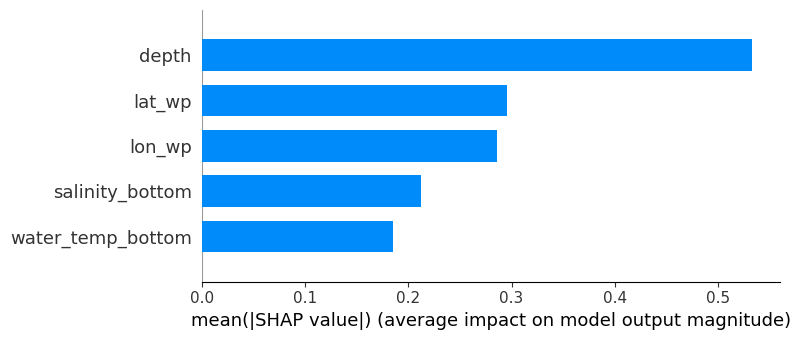

In [70]:
shap_values = shap.TreeExplainer(regressor).shap_values(X_train)
rf_shap_values = shap.TreeExplainer(regressor).shap_values(X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Through the SHAP values, it can be observed that depth and latitude are positively correlated to the target variable whereas longitude appears to be negatively correlated while the remaining two features show weak correlation.

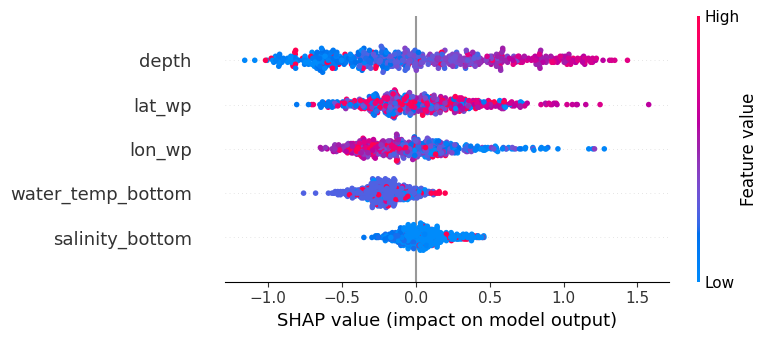

In [71]:
f = plt.figure()
shap.summary_plot(rf_shap_values, X_test)

In [83]:
X = X.drop('year_wp', axis=1)
X100 = shap.utils.sample(X, 100)
explainer_boost = shap.Explainer(regressor, X100)
shap_values_boost = explainer_boost(X)

100%|===================| 7570/7580 [01:40<00:00]        

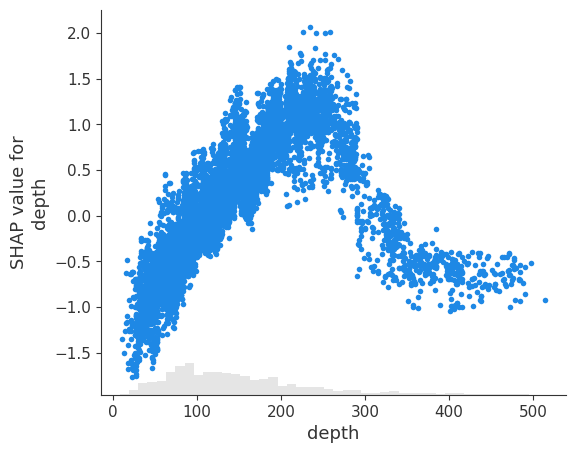

In [87]:
shap.plots.scatter(shap_values_boost[:,"lat_wp"])

For this actual value of 1.158, it can be observed that having a very low (negative) value in longitude increases the value for our prediction, therefore confirming our belief of a negative correlation between longitude and the mass of the observed fish. Further, positive values in depth, latitude and water temperature also seem to increase the value obtained by our function. Finally, a high value in salinity, seems to have a negligibly negative impact on the prediction.  

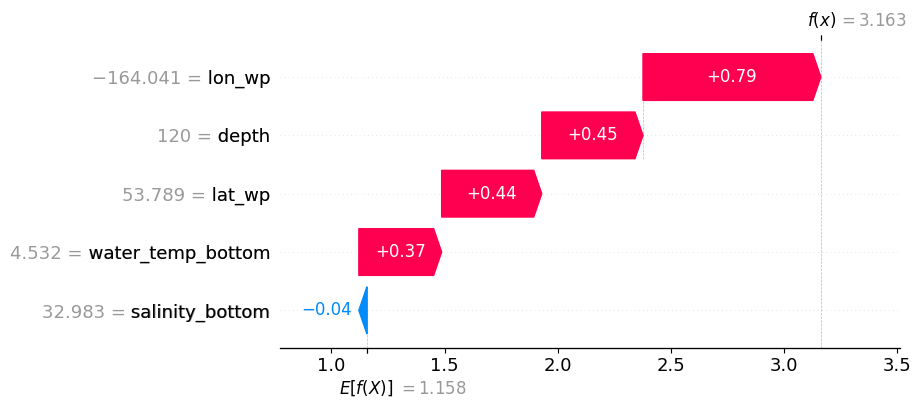

In [88]:
shap.plots.waterfall(shap_values_boost[sample_ind])

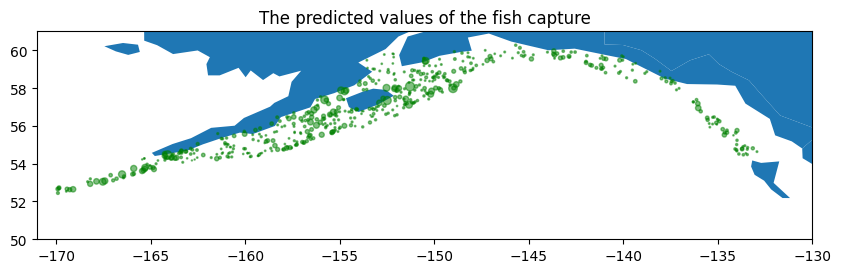

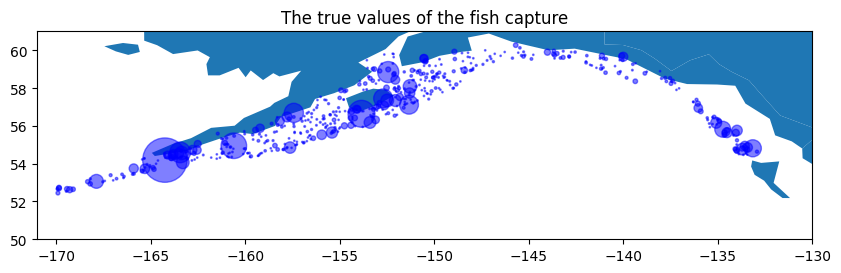

In [113]:
geometry = [Point(xy) for xy in zip(X_test['lon_wp'], X_test['lat_wp'])]
gdf = GeoDataFrame(X_test, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), markersize=np.exp(y_pred), color='green',alpha=0.5)
plt.xlim([-171, -130])
plt.ylim([50, 61])
plt.title("The predicted values of the fish capture")
gdf.plot(ax=world.plot(figsize=(10, 6)), markersize=np.exp(y_test), color='blue',alpha=0.5)
plt.xlim([-171, -130])
plt.ylim([50, 61])
plt.title("The true values of the fish capture")
plt.show()